# Grammatical Gender and Semantic Gender on Political Embeddings 
$^{\star}$ *Political Embeddings: Embeddings trained on a Political Discourse Corpus.*



In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from gensim.models.word2vec import Word2Vec


# loading trained word2vec model trained on the corpus of legislation XIV
model = Word2Vec.load('../models/legislature_XIV/word2vec_legis_XIV.model')


In [2]:
# size of embeddings
print("Size of embeddings: ", model.wv.vector_size)

Size of embeddings:  100


### 1st Attempt to extract semantic gender direction using PCA

In [9]:
import numpy as np
from sklearn.decomposition import PCA

# gender definition pairs
gender_def = [['reine', 'roi'],['femmes','hommes'], ['femme','homme'], ['madame', 'monsieur'], ["mère", "père"], ['fille', 'garçon'], ['tante', 'oncle'], ['grand-mère', 'grand-père']]
# ['fille', 'garçon']
# female - male vectors
diff_gender_vect = [model.wv.get_vector(male) - model.wv.get_vector(female) for female, male in gender_def]

# extract semantic gender direction
X = np.array(diff_gender_vect)
pca = PCA(n_components=1)
pca.fit(X)
d_pca = pca.components_ 


# plot the projections of the gender_def pairs on the d_pca direction
n_g_def = len(gender_def) # nb of pairs
y_ = np.linspace(1, 20, n_g_def)   # y-axis for the plot (used to separate gender_def pairs)
x_ = np.array([[d_pca.dot(model.wv.get_vector(female))[0], d_pca.dot(model.wv.get_vector(male))[0]] for female, male in gender_def])

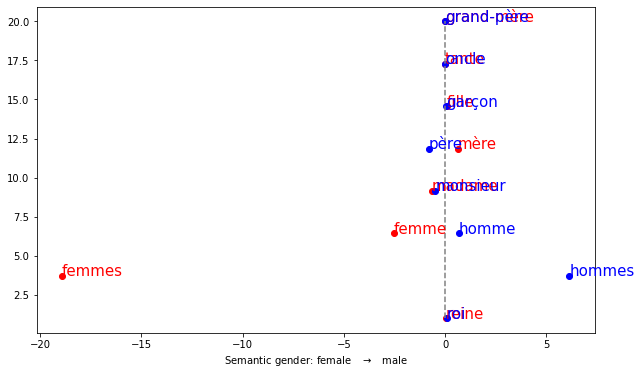

In [10]:
# plot of words on the semantic gender axis
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.scatter(x_[:, 0], y_, color='red')  # female component
plt.scatter(x_[:, 1], y_, color='blue') # male component

# annotation of the points on the scatter plot
for label, x, y in zip(np.array(gender_def)[:, 0], x_[:, 0], y_):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='red')
  
for label, x, y in zip(np.array(gender_def)[:, 1], x_[:, 1], y_):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='blue')

plt.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')

plt.xlabel(r"Semantic gender: female   $\rightarrow$   male")
plt.show()


Since PCA does not work well in extracting the semantic gender direction, one might be tempted to use LDA to classify females and males. However, this approach can result in a biased result as the algorithm can also learn separate the 2 classes based on their grammatical gender. 

Therefore, we will 
- first try extract the grammatical gender direction
- remove the grammatical gender component from the word embeddings
- finally, use LDA on the new embeddings clean from grammatical gender information. 

### Extracting grammatical gender direction 

In [146]:
# loading grammatical gender word lists
with open("../data/grammatical_masculine.txt", "r") as output:
    masc_gram = output.read()
    output.close()

with open("../data/grammatical_feminine.txt", "r") as output:
    fem_gram = output.read()
    output.close()

fem_gram = fem_gram.split('\n')
masc_gram = masc_gram.split('\n')

# embeddings of grammatical gender words
X_fem, X_masc = [], []
x_list_fem, x_list_masc = [], []  # list of grammatically gendered words used in X
for fem in fem_gram:
    # some words might not have existed in the corpus of fasttext
    try:
        X_fem.append(model.wv.get_vector(fem))
        x_list_fem.append(fem)
    except:
        continue
for masc in masc_gram:
    try:
        X_masc.append(model.wv.get_vector(masc))
        x_list_masc.append(masc)
    except:
        continue

x_list_fem, x_list_masc = np.array(x_list_fem), np.array(x_list_masc)  # final lists of grammatically gender words

# prepare data for LDA
X_fem, X_masc = np.array(X_fem), np.array(X_masc)
y = np.concatenate((np.zeros(len(X_masc)), np.ones(len(X_fem))))   # 0 for masculine, 1 for feminine
X = np.concatenate((X_masc, X_fem), axis=0)

# shuffle (for safety) 
np.random.seed(42)
idx = np.random.choice(np.arange(len(X)), size=len(X), replace=False)
X = X[idx]
y = y[idx]

# train and test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, random_state=13)

In [147]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)

lda.fit(X_train, y_train)
print(lda.score(X_train, y_train), lda.score(X_test, y_test))

# grammatical gender direction 
d_gram = lda.scalings_/(np.linalg.norm(lda.scalings_, ord=2))
d_gram = - d_gram   # to have feminine on the left, masculine on the right
d_gram = d_gram.reshape(-1, )

0.8472979672781359 0.8333333333333334


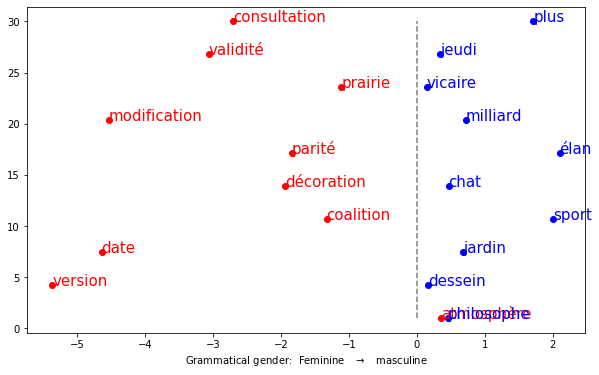

In [148]:
# randomly select some words (from the grammatical gender lists) for test
np.random.seed(42)
n_words = 10
idx_fem = np.random.choice(len(x_list_fem), size=n_words, replace=False)
idx_masc = np.random.choice(len(x_list_masc), size=n_words, replace=False)

# prepare data for the plot
y_ = np.linspace(1, 3*n_words, n_words)

x_fem = (X_fem[idx_fem]@d_gram).reshape(-1, )
x_masc= (X_masc[idx_masc]@d_gram).reshape(-1, )



# scatter plot of words
plt.figure(figsize=(10, 6))

plt.scatter(x_fem, y_, color='red')   # female
plt.scatter(x_masc, y_, color='blue')  # male

# annotation of words 
for label, x, y in zip(x_list_fem[idx_fem], x_fem, y_):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='red')

  
for label, x, y in zip(x_list_masc[idx_masc], x_masc, y_):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='blue')
  
plt.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')

plt.xlabel(r"Grammatical gender:  Feminine   $\rightarrow$   masculine")
plt.show()

### 2nd Attempt to extract semantic gender direction using LDA

In [149]:
import os 
# os.chdir('../code/')
from generate_gram_gender_lists import *

masc_animate, fem_animate = masc_fem_animate_words("../data/zmigrod_animate_words.tsv")
masc_animate, fem_animate = list(masc_animate), list(fem_animate)
masc_animate.extend(['homme', 'député', 'auteur', 'dirigeant', 'client', 'joueur', 'héros', 'animateur', 'jeune-homme', 'grand-père', 'Maître', 'psychologue', 'hôte', 'coursier', 'psychologue', 'gouverneur', 'orateur', 'rappeur', 'émigré', 'trésorier', 'intervenant', 'journaliste', 'empereur', 'malade', 'responsable', 'auteur-compositeur-interprète', 'vétérant', 'beau-frère', 'seigneur', 'kurde', 'militant', 'professeur', 'fils', 'romancier', 'colonel', 'père', 'entraîneur', 'commandant', 'carrossier', 'chevalier', 'indien', 'vénézuélien', 'développeur', 'spécialiste', 'tirailleur', 'réalisateur', 'secrétaire', 'architecte', 'commentateur', 'ministre', 'lanceur', 'imitateur', 'libre-penseur', 'frère', 'organisateur', 'clergé', 'artisan', 'ingénieur', 'médecin', 'acheteur', 'investisseur', 'représentant', 'recruteur', 'grand-maître', 'pèlerin', 'ambassadeur', 'italien', 'statisticien', 'passager', 'éditeur-en-chef'])
fem_animate.extend(['femme', 'héroïne', 'dame', 'grand-mère', 'reine', 'joueuse','sœur', 'petite-fille', 'nounou', 'enfant', 'surveillante', 'mère', 'serveuse', 'journaliste', 'ministre', 'vice-présidente'])
masc_animate.extend('monsieur, homme, père, garçon, fils, grand-père, oncle'.split(', '))
fem_animate.extend('femme, madame, dame, fille, mère, grand-mère, tante'.split(', '))

In [150]:
# embeddings of grammatical gender words
X_fem, X_masc = [], []
x_list_fem, x_list_masc = [], []  # list of grammatically gendered words used in X
for fem in fem_animate:
    # some words might not have existed in the corpus of fasttext
    try:
        X_fem.append(model.wv.get_vector(fem) - (model.wv.get_vector(fem) @ d_gram) * d_gram)
        x_list_fem.append(fem)
    except:
        continue
for masc in masc_animate:
    try:
        X_masc.append(model.wv.get_vector(masc) - (model.wv.get_vector(masc) @ d_gram) * d_gram)
        x_list_masc.append(masc)
    except:
        continue

x_list_fem, x_list_masc = np.array(x_list_fem), np.array(x_list_masc)  # final lists of grammatically gender words

# prepare data for LDA
X_fem, X_masc = np.array(X_fem), np.array(X_masc)
y = np.concatenate((np.zeros(len(X_masc)), np.ones(len(X_fem))))   # 0 for masculine, 1 for feminine
X = np.concatenate((X_masc, X_fem), axis=0)

# shuffle (for safety) 
np.random.seed(42)
idx = np.random.choice(np.arange(len(X)), size=len(X), replace=False)
X = X[idx]
y = y[idx]

# train and test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, random_state=42)

In [151]:
X_train.shape

(220, 100)

In [152]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)

lda.fit(X_train, y_train)
print(lda.score(X_train, y_train), lda.score(X_test, y_test))

# grammatical gender direction 
d_sem = lda.scalings_/(np.linalg.norm(lda.scalings_, ord=2))
d_sem = - d_sem   # to have feminine on the left, masculine on the right

0.85 0.7333333333333333


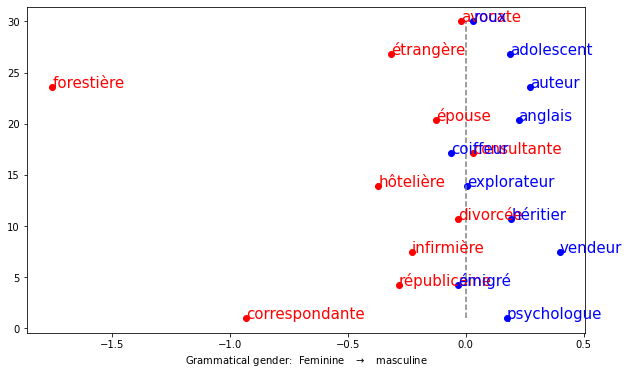

In [153]:
# randomly select some words (from the grammatical gender lists) for test
np.random.seed(42)
n_words = 10
idx_fem = np.random.choice(len(x_list_fem), size=n_words, replace=False)
idx_masc = np.random.choice(len(x_list_masc), size=n_words, replace=False)

# prepare data for the plot
y_ = np.linspace(1, 3*n_words, n_words)

x_fem = (X_fem[idx_fem]@d_sem).reshape(-1, )
x_masc= (X_masc[idx_masc]@d_sem).reshape(-1, )



# scatter plot of words
plt.figure(figsize=(10, 6))

plt.scatter(x_fem, y_, color='red')   # female
plt.scatter(x_masc, y_, color='blue')  # male

# annotation of words 
for label, x, y in zip(x_list_fem[idx_fem], x_fem, y_):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='red')

  
for label, xx, yy in zip(x_list_masc[idx_masc], x_masc, y_):
    plt.annotate(label, xy=(xx, yy), xytext=(0, 0), textcoords='offset points', fontsize=15,
                     color='blue')
  
plt.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')

plt.xlabel(r"Grammatical gender:  Feminine   $\rightarrow$   masculine")
plt.show()